In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np


import torch
from torch import tensor
import torch.nn.functional as F
from torch import nn

from trl import SFTTrainer
from transformers import TrainingArguments, Trainer
from typing import Tuple
from datasets import load_dataset, Dataset
from tqdm import tqdm

output_dir = "data/"

In [2]:
import os

project_name = 'bert'
repo_dir = os.path.dirname(os.getcwd())
results_dir = os.path.join(repo_dir, 'models', project_name)

In [3]:
bert_models = [
    'microsoft/deberta-v3-large',
    "bert-base-uncased",
    'google-bert/bert-base-uncased',
    'google-bert/bert-base-cased',
]

## load 
    - model
    - tokenizer
    - dataset

In [4]:
# load pre-trained model and its tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "bert-base-uncased"
# binary classification: 1, 0
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = model.config.max_position_embeddings
print('max_length', tokenizer.model_max_length)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


max_length 512


In [5]:
pnum = [p.numel() for p in model.parameters()]
print("Number of parameters:", sum(pnum))
# model.parameters

Number of parameters: 109483778


In [6]:
from datasets import load_from_disk
ds = load_from_disk('/home/yuan/results/epitope/epitope_bert.ds')

Loading dataset from disk:   0%|          | 0/23 [00:00<?, ?it/s]

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3598367
    })
    valid: Dataset({
        features: ['text', 'label', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 635007
    })
    test: Dataset({
        features: ['text', 'label', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 747067
    })
})

In [8]:
ds['train'][0]['labels']

[1]

## evaluate model before fine-tuning

In [48]:
# evaluate base model using test dataset
from torch.utils.data import DataLoader

model.eval()

original_stat = {
    'labels': [],
    'predictions': [],
    'scores': [],
}

# convert test dataset to dataloader
eval_dataloader = DataLoader(ds['test'], batch_size=8, shuffle=True)
for batch in eval_dataloader:
    # true labels
    original_stat['labels'].extend(batch["label"].tolist())
    with torch.no_grad():    
        inputs = tokenizer(batch['text'], padding='max_length', truncation=True, return_tensors='pt').to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        # probabilities of label=1
        scores = F.softmax(logits, dim=-1)[:,-1].tolist()
        original_stat['scores'].extend(scores)
        # predicted labels
        predictions = torch.argmax(logits, dim=-1)
        original_stat['predictions'].extend(predictions.tolist())
#         break
# stat

In [49]:
# scores
from trainer_plot import TrainerPlot

TrainerPlot.scores(original_stat)

Total:  747067
true classifications: Counter({0: 747067})
predictions:  Counter({1: 747066, 0: 1})


/home/yuan/anaconda3/envs/unsloth_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'recall': 0.0,
 'precision': 0.0,
 'F1 score': 0.0,
 'accuracy': 1.3385680266964007e-06}

confusion matrix:
 [[     1 747066]
 [     0      0]]


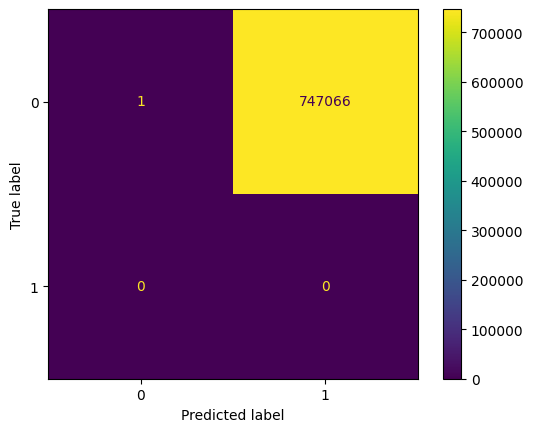

In [50]:
TrainerPlot.cm(original_stat)

/home/yuan/anaconda3/envs/unsloth_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/yuan/anaconda3/envs/unsloth_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/yuan/anaconda3/envs/unsloth_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


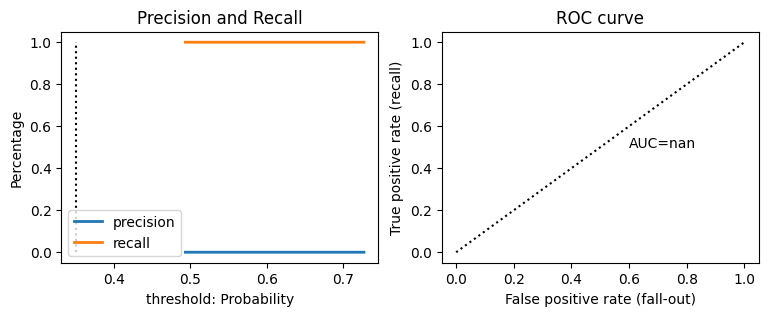

{'AUC': nan}

In [51]:
TrainerPlot.recall_roc(original_stat, .35)

## supervised fine-tuning

In [9]:
import torch
from transformers import TrainerCallback
from sklearn.metrics import precision_score, recall_score,accuracy_score

class CustomCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, **kwargs):
        model.eval()
        # Assuming the evaluation dataset has 'labels' and 'predictions' fields
        eval_dataloader = kwargs['eval_dataloader']
        true_labels = []
        predict_labels = []
        for batch in eval_dataloader:
            true_labels.extend(batch['labels'].cpu().tolist())
            
            inputs = batch['input_ids'].to(args.device)            
            with torch.no_grad():
                outputs = model(inputs)
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)
                predict_labels.extend(predictions.cpu().tolist())

        # print(true_labels, predict_labels)
        accuracy = accuracy_score(true_labels, predict_labels)
        recall = recall_score(true_labels, predict_labels)
        print(f"Evaluation: Accuracy={accuracy:.4f}, recall={recall:.4f}")

In [10]:
import torch
from transformers import TrainingArguments, training_args, Trainer

args = TrainingArguments(
    per_device_train_batch_size=16,
    num_train_epochs=1,
    learning_rate=1e-5,
    
    gradient_accumulation_steps=1,
    warmup_steps=10,
    # fp16=not torch.cuda.is_bf16_supported(),
    # bf16=torch.cuda.is_bf16_supported(),
    logging_steps=1,
    optim=training_args.OptimizerNames.ADAMW_TORCH,
    weight_decay=0.001,
    lr_scheduler_type="cosine",
    seed=3407,
    output_dir=results_dir + "outputs",
    report_to="none",
    group_by_length=True,
    evaluation_strategy="steps",
    eval_steps=20,
)


trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=ds['train'],
    eval_dataset=ds['valid'],
    args=args,
    callbacks=[CustomCallback()],
)

stat = trainer.train()

/home/yuan/anaconda3/envs/unsloth_env/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_360807/3043137997.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


KeyboardInterrupt: 

In [ ]:
stat

In [ ]:
from trainer_plot import TrainerPlot

TrainerPlot.loss(trainer)

In [ ]:
# evaluation by valid dataset
eval_stat = trainer.evaluate()
print(eval_stat)

In [ ]:
# prediction using test dataset
from fine_tune import FineTune

stat = FineTune.trainer_predict(trainer, ds['test'])

In [ ]:
# scores
from trainer_plot import TrainerPlot

TrainerPlot.scores(stat)

In [ ]:
# confusion matrix
TrainerPlot.cm(stat)

In [ ]:
TrainerPlot.recall_roc(stat)

In [ ]:
ds['test']

In [30]:
print("save model, tokenizer, arguments and state into ", results_dir)
trainer.save_model(results_dir)
# pt format
torch.save(model, results_dir + "/bert.pt")
torch.save(tokenizer, results_dir + "/bert_tokenizer.pt")

save model, tokenizer, arguments and state into  /home/yuan/bio/machine_learning/model/bert_finacial


## prediction from fine-tuned model

In [31]:
# load model
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model0 = AutoModelForSequenceClassification.from_pretrained(results_dir)
tokenizer0 = AutoTokenizer.from_pretrained(results_dir)

In [32]:
model0

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [33]:
# prediction using test dataset
from fine_tune import FineTune

stat0 = FineTune.model_predict(model0, tokenizer0, ds['test'])

In [34]:
# scores
from trainer_plot import TrainerPlot

TrainerPlot.scores(stat0)

Total:  673
true classifications: Counter({1: 368, 0: 305})
predictions:  Counter({1: 359, 0: 314})


{'recall': 0.8804347826086957,
 'precision': 0.9025069637883009,
 'F1 score': 0.8913342503438789,
 'accuracy': 0.8826151560178306}

confusion matrix:
 [[270  35]
 [ 44 324]]


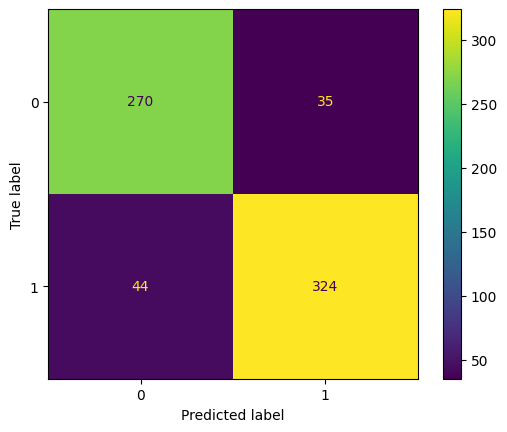

In [35]:
# confusion matrix
TrainerPlot.cm(stat0)

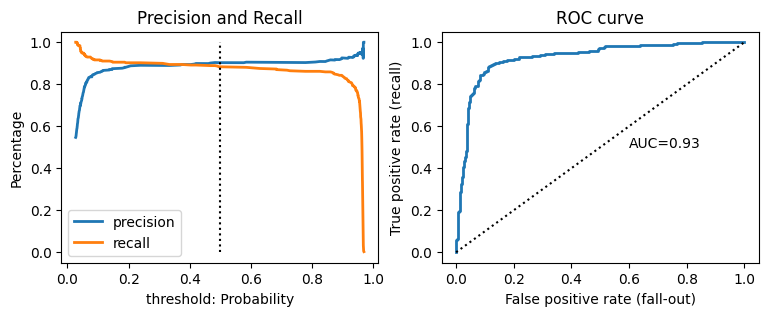

{'AUC': np.float64(0.9285103349964362)}

In [36]:
TrainerPlot.recall_roc(stat0)

In [ ]:
##################deprecated inthe future

In [23]:
import torch
import torch.nn.functional as F

# Decode a sample input
sample_input = ds["test"][0]["input_ids"]
decoded_input = tokenizer.decode(sample_input, skip_special_tokens=True)
print(f"Decoded input: {decoded_input}")

Decoded input: stock market update : semiconductor stocks underperform ; ice calls off ebay interest


In [24]:
import torch
import torch.nn.functional as F

with torch.no_grad():
    batch = val_X[:50].tolist()
    tokens = tokenizer(batch, padding=True, return_tensors="pt")
    tokens = {k: v.cuda() for k, v in tokens.items()}
    output = model(**tokens)
    logits = output[0].cpu()
    scores = F.softmax(logits, dim=1)[:,1]
    for i, text in enumerate(batch):
        lg = np.round(logits[-1,:].tolist(), 4)
        print('\n'.join([
            f"Text: {text[:100]}",
            f"logits={lg}\tScore: {scores[i].item():.4f}",
            '\n',
        ]))

NameError: name 'val_X' is not defined